In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from EEGModels import EEGNet
from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
import h5py

In [3]:
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

In [34]:
# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subjects = range(1,10)
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subjects, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.annotations.rename(dict(T1="hands", T2="feet"))  # as documented on PhysioNet
raw.set_eeg_reference(projection=True)

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    event_id=["hands", "feet"],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Extracting EDF parameters from /Users/isita/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/isita/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/isita/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/isita/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T0', 'feet', 'hands']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
405 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 405 events and 801 original time points ...
0 bad epochs dropped


In [36]:
# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data() # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 64, 801

In [37]:
print(X.shape, y.shape)

(405, 64, 801) (405,)


In [38]:
X_train      = X[0:224,]
Y_train      = y[0:224]
X_validate   = X[224:320,]
Y_validate   = y[224:320]
X_test       = X[320:416]
Y_test       = y[320:416]

In [39]:
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (224, 64, 801, 1)
224 train samples
85 test samples


In [40]:
import time
import tensorflow as tf

class timing(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
    
    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.start_time
        print(f"Total training time: {self.total_time:.2f} seconds")

In [41]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
with h5py.File('./tmp/mi_checkpoint.h5', 'w') as f:
    # This creates 2 attributes of arrays of different np.float types:
    arr_in = np.array([1.0,2.0,3.0])
    f.attrs['as_float64'] = arr_in
    # arr_in.dtype = np.float128
    # f.attrs['as_float128'] = arr_in
checkpointer = ModelCheckpoint(filepath='./tmp/mi_checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during 
# optimization to balance it out. This data is approximately balanced so we 
# don't need to do this, but is shown here for illustration/completeness. 
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer, timing()], 
                        class_weight = class_weights)

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.69312, saving model to ./tmp/mi_checkpoint.h5
14/14 - 1s - loss: 0.6932 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.5104 - 1s/epoch - 81ms/step
Epoch 2/300


/opt/anaconda3/envs/zazu2/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.69312 to 0.69307, saving model to ./tmp/mi_checkpoint.h5
14/14 - 1s - loss: 0.6931 - accuracy: 0.5223 - val_loss: 0.6931 - val_accuracy: 0.5104 - 958ms/epoch - 68ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.69307
14/14 - 1s - loss: 0.6945 - accuracy: 0.4598 - val_loss: 0.6931 - val_accuracy: 0.5104 - 915ms/epoch - 65ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.69307
14/14 - 1s - loss: 0.6933 - accuracy: 0.4821 - val_loss: 0.6931 - val_accuracy: 0.5104 - 949ms/epoch - 68ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.69307
14/14 - 1s - loss: 0.6917 - accuracy: 0.5312 - val_loss: 0.6931 - val_accuracy: 0.5104 - 922ms/epoch - 66ms/step
Epoch 6/300

Epoch 6: val_loss improved from 0.69307 to 0.69305, saving model to ./tmp/mi_checkpoint.h5
14/14 - 1s - loss: 0.6942 - accuracy: 0.4866 - val_loss: 0.6931 - val_accuracy: 0.5104 - 919ms/epoch - 66ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.69305

In [42]:
# load optimal weights
# model.load_weights('./tmp/mi_checkpoint.h5')

###############################################################################
# can alternatively used the weights provided in the repo. If so it should get
# you 93% accuracy. Change the WEIGHTS_PATH variable to wherever it is on your
# system.
###############################################################################

# WEIGHTS_PATH = /path/to/EEGNet-8-2-weights.h5 
# model.load_weights(WEIGHTS_PATH)

###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

3/3 [==============================] - 0s 12ms/step
Classification accuracy: 0.588235 


In [43]:



############################# PyRiemann Portion ##############################

# code is taken from PyRiemann's ERP sample script, which is decoding in 
# the tangent space with a logistic regression

# n_components = 2  # pick some components

# # set up sklearn pipeline
# clf = make_pipeline(XdawnCovariances(n_components),
#                     TangentSpace(metric='riemann'),
#                     LogisticRegression())

# preds_rg     = np.zeros(len(Y_test))

# # reshape back to (trials, channels, samples)
# X_train      = X_train.reshape(X_train.shape[0], chans, samples)
# X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# # train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# # labels need to be back in single-column format
# clf.fit(X_train, Y_train.argmax(axis = -1))
# preds_rg     = clf.predict(X_test)

# # Printing the results
# acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
# print("Classification accuracy: %f " % (acc2))

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

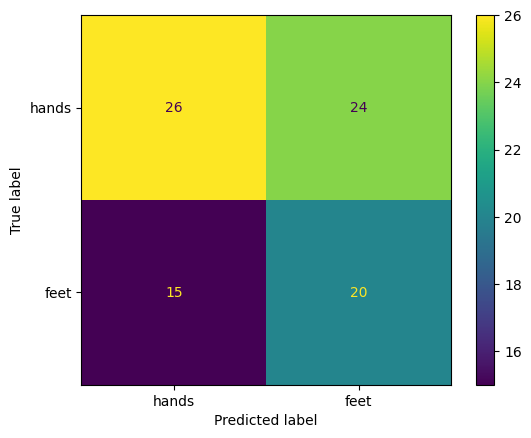

In [45]:
# plot the confusion matrices for both classifiers
names        = ['hands', 'feet']
# plt.figure(0)
confusion_matrix_1 = confusion_matrix(preds, Y_test)

# plt.figure(1)
# confusion_matrix_2 = confusion_matrix(preds_rg, Y_test)

disp1 = ConfusionMatrixDisplay(confusion_matrix_1, display_labels = names)
disp1.plot()

# disp2 = ConfusionMatrixDisplay(confusion_matrix_2, display_labels = names)
# disp2.plot()

In [46]:
print(classification_report(preds, Y_test))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57        50
           1       0.45      0.57      0.51        35

    accuracy                           0.54        85
   macro avg       0.54      0.55      0.54        85
weighted avg       0.56      0.54      0.54        85

